# Import

In [1]:
from utils.plot_config import *
import pandas as pd
import numpy as np
import os

import matplotlib.colors as mcolors
from matplotlib.ticker import FixedLocator, NullFormatter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches

In [2]:
plt.rcParams['axes.linewidth'] = 2

# Data

In [3]:
models = [
    'DLinear', 'PatchTST', 'TimesNet', 'iTransformer', 
    'TimeMixer', 'CALF',  'TimeLLM', 'OFA'
]
datasets = [
    'SPX500', 'Apple', 'MSFT', 
    'Crude_Oil', 'Gold', 'Natural_Gas', 
    'Exchange_Rate_Report', 'Financial_Aid_State'
]

datasets_map = {
    'SPX500': 'S&P 500',
    'Apple': 'Apple',
    'MSFT': 'Microsoft',
    'Crude_Oil': 'Crude Oil',
    'Gold': 'Gold',
    'Natural_Gas': 'Natural Gas',
    'Exchange_Rate_Report': 'Exchange Rate',
    'Financial_Aid_State': 'Financial Aid'
}

# Plot

## Test

In [3]:
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)

In [ ]:
nrows = 2
ncols = 4
assert nrows * ncols >= len(datasets)
fig, axes = plt.subplots(nrows, ncols, figsize=(43, 12))

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        if i * ncols + j >= len(datasets): continue
        
        dataset = datasets[i * ncols + j]
        # print(dataset)
        
        if dataset == 'Financial_Aid_State':
            sl, pl = 10, 1
            target = 'need_amt'
        else: 
            sl, pl = 96, 24
            if dataset == 'Exchange_Rate_Report':
                target = 'Canadian dollar(CAD)'
            else:
                target = 'Close/Last'
                
        if dataset == 'SPX500':
            ax.set_title('S&P 500', fontweight='bold')
        else:
            ax.set_title(
                dataset.replace('_', ' ').replace(' State', ''), 
                fontweight='bold'
            )
        
        # y-axis label
        y_label = target.replace('_', ' ').title()
        if target == 'need_amt':
            y_label = 'Need Amount'
        elif target == 'Canadian dollar(CAD)':
            y_label = 'Canadian Dollar'
        ax.set_ylabel(y_label)
        
        ground_truth_plotted = False
        for model in models:
            # print(model)
            result_path = os.path.join('results', dataset, f'{model}_sl_{sl}_pl_{pl}')
            if model in ['CALF', 'OFA', 'TimeLLM']:
                result_path += '_id_ori'
            
            df = pd.read_csv(os.path.join(result_path, '1', 'test.csv'))
            
            if dataset == 'Financial_Aid_State':
                df = df.groupby('Date')[[target, 'Predicted_'+target]].sum().reset_index()
                df.sort_values(by='Date', inplace=True)
                df['Date'] = df['Date'].astype('str')
            else: 
                df['Date'] = pd.to_datetime(df['Date'])
                df.sort_values(by='Date', inplace=True)
                df = df.iloc[:pl*2].reset_index(drop=True)
           
            if not ground_truth_plotted:
                if df[target].dtype == 'object':
                    df[target] = df[target].apply(
                        lambda x: x.replace('$', '')
                    ).astype('float')
                    
                scaler = MinMaxScaler()
                df[target] = scaler.fit_transform(
                    df[target].values.reshape(-1, 1)
                )
                
                ax.plot(df['Date'], df[target], label='Ground Truth', linewidth=3.5)
                ground_truth_plotted = True
            
            df['Predicted_'+target] = scaler.transform(
                df['Predicted_'+target].values.reshape(-1, 1)
            )
            ax.plot(df['Date'], df['Predicted_'+target], label=model if model  != 'OFA' else 'GPT4TS')
        
        if dataset != 'Financial_Aid_State':
            x_first_tick = df['Date'].min()
            x_last_tick = df['Date'].max() 
            x_major_ticks = 4
            ax.set_xticks(
                [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
            )
        # else:
            # ax.xaxis.set_major_locator(MultipleLocator(base=1))
            
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min-.1, y_max +.1)
            
        if i + j == 0:
            ax.legend(loc='lower center', ncol=9, bbox_to_anchor=(2.35, -1.85))

plt.suptitle('Forecasting Comparison on Test Set',fontweight='bold')
plt.subplots_adjust(wspace=0.23, hspace=0.35)
plt.savefig('results/plot2.jpg', dpi=200, bbox_inches="tight")
plt.show()

## Few-shot

In [5]:
total_df = pd.read_csv('results/results.csv')
df = total_df[(total_df['dataset'] == 'Financial_Aid_State')]
df.head(3)

,dataset,model,iteration,mae,mse,seq_len,pred_len,percent,memory,time
395,Financial_Aid_State,CALF,1,0.88415,1.7533,10,1,100,962.0,1.3
396,Financial_Aid_State,CALF,2,0.83834,1.6984,10,1,100,965.4,1.9
397,Financial_Aid_State,CALF,3,0.76708,1.4563,10,1,100,961.3,1.5


In [4]:
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)

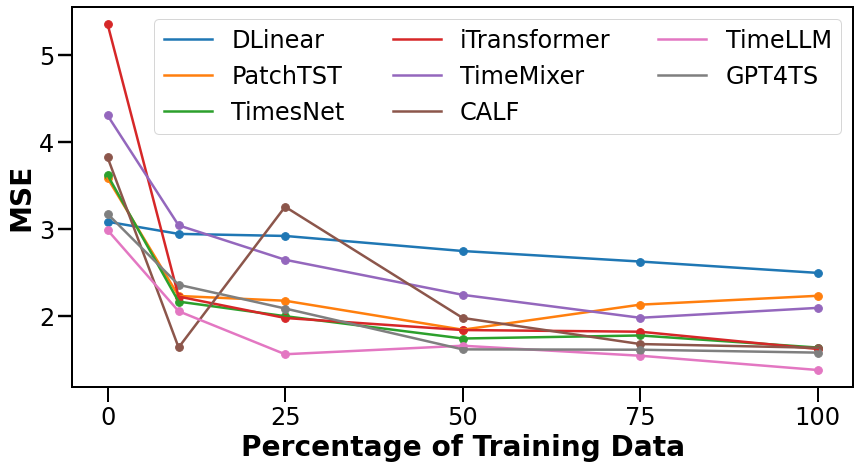

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for model in models:
    data = df[df['model'] == model]
    label  = model if model != 'OFA' else 'GPT4TS'
    
    data = data.groupby('percent')['mse'].mean().reset_index()
    
    ax.plot(data['percent'], data['mse'], label=label)
    ax.scatter(data['percent'], data['mse'], s=60)
    
ax.set_xlabel('Percentage of Training Data', fontweight='bold')
ax.set_ylabel('MSE', fontweight='bold')
ax.xaxis.set_major_locator(MultipleLocator(base=25))

plt.legend(ncols=3)
plt.savefig('results/Financial_Aid_State_few_shot.jpg', dpi=200, bbox_inches="tight")
plt.show()

In [15]:
df = total_df[(total_df['dataset'] == 'Exchange_Rate_Report')]

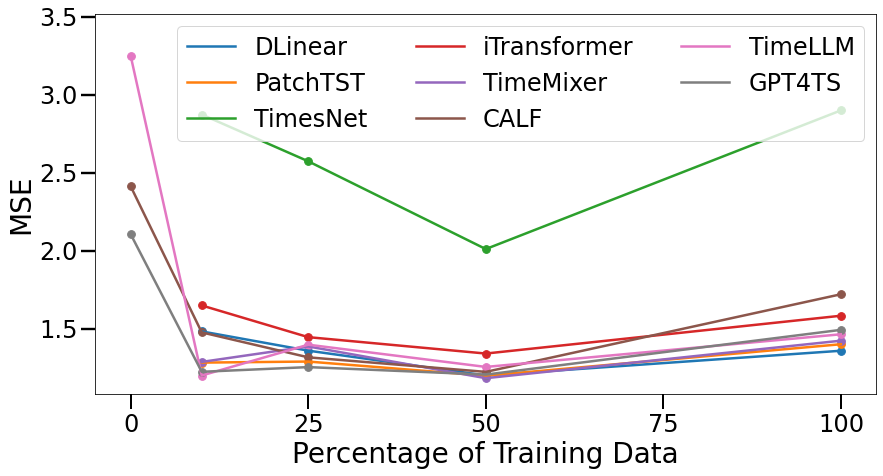

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for model in models:
    data = df[df['model'] == model]
    label  = model if model != 'OFA' else 'GPT4TS'
    
    data = data.groupby('percent')['mse'].mean().reset_index()
    
    ax.plot(data['percent'], data['mse'], label=label)
    ax.scatter(data['percent'], data['mse'], s=60)
    
ax.set_xlabel('Percentage of Training Data')
ax.set_ylabel('MSE')

y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min, y_max*1.05)
ax.xaxis.set_major_locator(MultipleLocator(base=25))

plt.legend(ncols=3, loc='upper right')
# plt.savefig('results/Financial_Aid_State_test.jpg', dpi=200, bbox_inches="tight")
plt.show()

## Financial Aid State

In [ ]:
df = pd.read_csv('data/Financial_Aid_State.csv')
df = df.groupby('Date')['need_amt'].sum().reset_index()

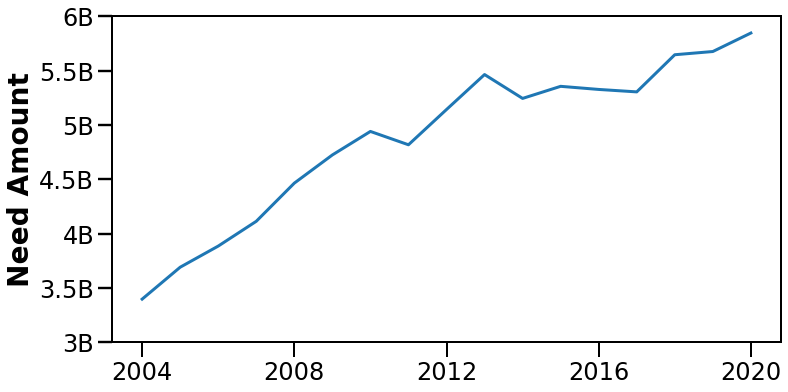

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['Date'], df['need_amt'], linewidth=3)
# ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Need Amount', fontweight='bold')
ax.xaxis.set_major_locator(MultipleLocator(base=4))

label_text = []
scale, unit = 1e9, 'B'
for loc in plt.yticks()[0]:
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/scale:0.5g}{unit}') 
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(label_text)

plt.savefig('results/Financial_Aid_State.jpg', dpi=200, bbox_inches="tight") 
plt.show()

### With Vlines and Splits

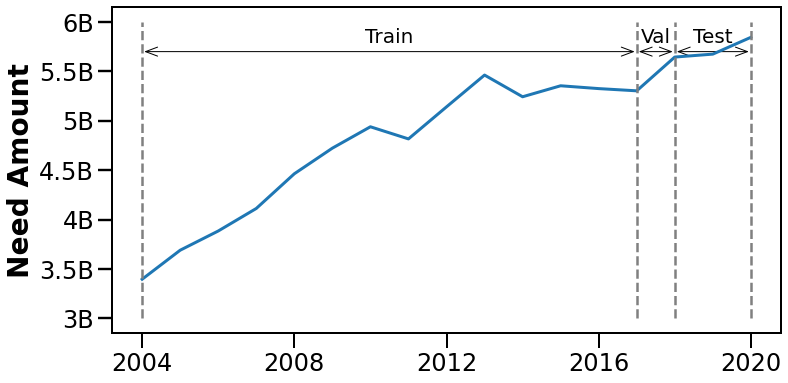

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(df['Date'], df['need_amt'], linewidth=3)
# ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Need Amount', fontweight='bold')
ax.xaxis.set_major_locator(MultipleLocator(base=4))

label_text = []
scale, unit = 1e9, 'B'
for loc in plt.yticks()[0]:
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/scale:0.5g}{unit}') 
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(label_text)

y_min, y_max = ax.get_ylim()

x_first_tick = df['Date'].min()
x_last_tick = df['Date'].max() 

years = (x_last_tick - x_first_tick) + 1
num_train = int(years * 0.8)
num_val = int(years * 0.1)
lnum_test = years - num_train - num_val

train_end = x_first_tick + num_train
val_end = train_end + num_val
text_y = y_max*.95

for label, start, end in [
    ('Train', x_first_tick, train_end), 
    ('Val', train_end, val_end),
    ('Test', val_end, x_last_tick)]:
    arr = mpatches.FancyArrowPatch((start, text_y), (end, text_y),
                            arrowstyle='<->,head_width=.15', mutation_scale=30)
    ax.add_patch(arr)
    ax.annotate(label, (.5, 1), xycoords=arr, ha='center', va='bottom', fontsize=20)    

for x in [x_first_tick, train_end, val_end, x_last_tick]:
    ax.vlines(x, y_min, y_max, colors='gray', linestyles='dashed')

plt.savefig('results/Financial_Aid_State_vline.jpg', dpi=200, bbox_inches="tight") 
plt.show()

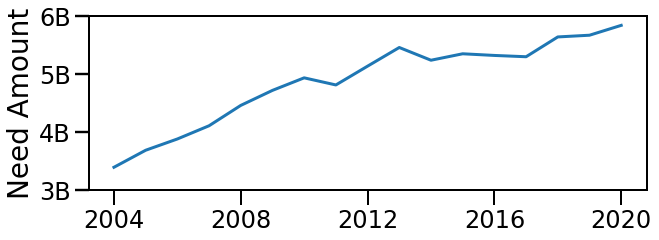

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3.2))
ax.plot(df['Date'], df['need_amt'], linewidth=3)
ax.set_ylabel('Need Amount')
ax.xaxis.set_major_locator(MultipleLocator(base=4))

label_text = []
scale, unit = 1e9, 'B'
for loc in plt.yticks()[0]:
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/scale:0.5g}{unit}') 

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(label_text)

plt.savefig('results/Financial_Aid_State_narrow.jpg', dpi=100, bbox_inches="tight") 
plt.show()

## Others

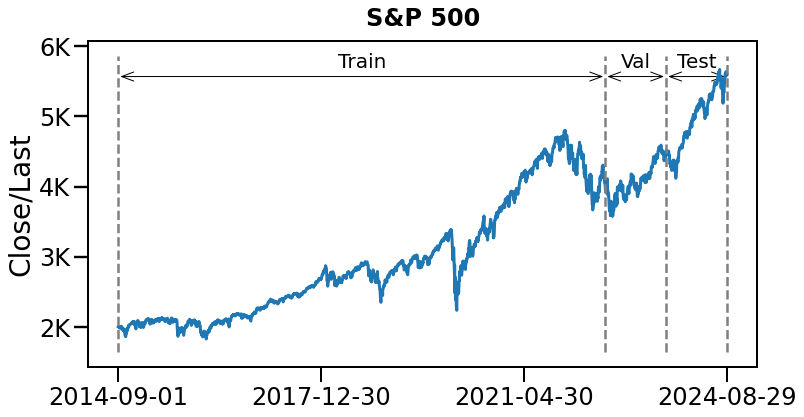

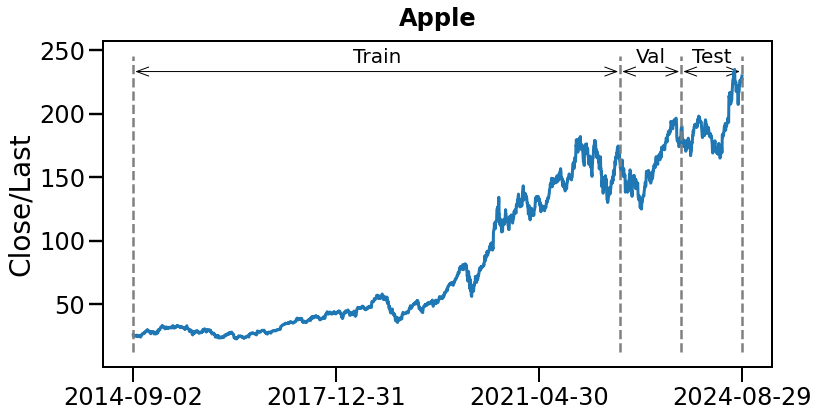

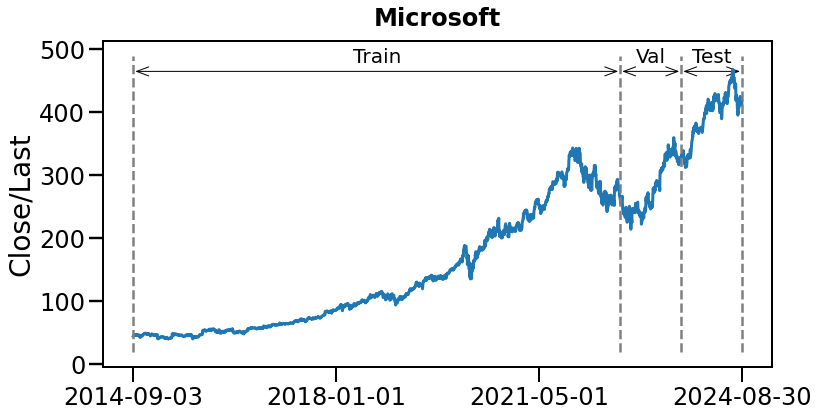

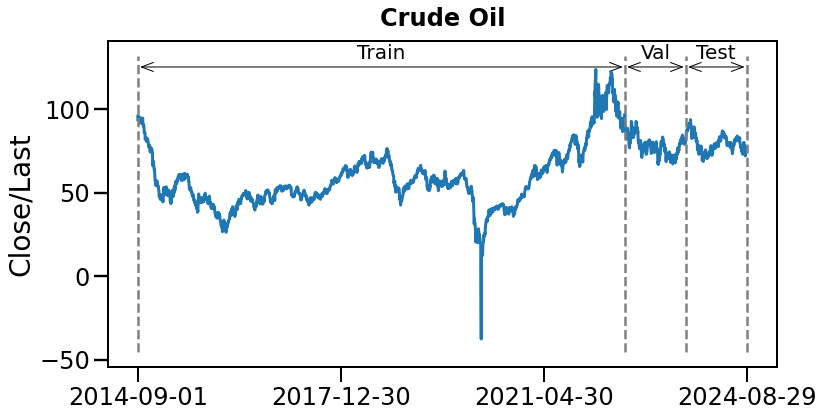

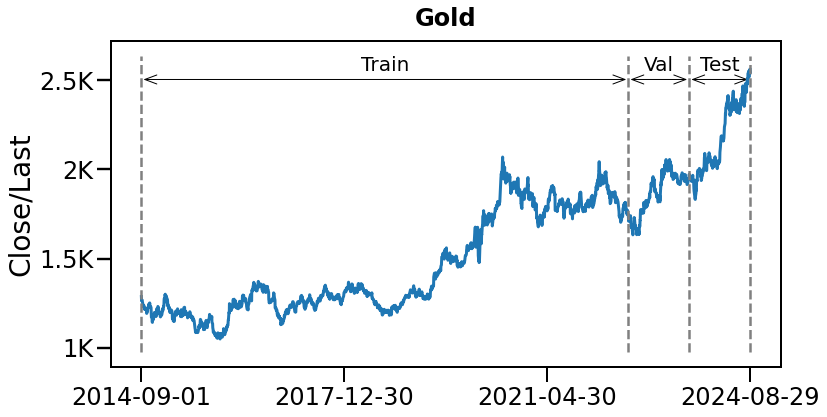

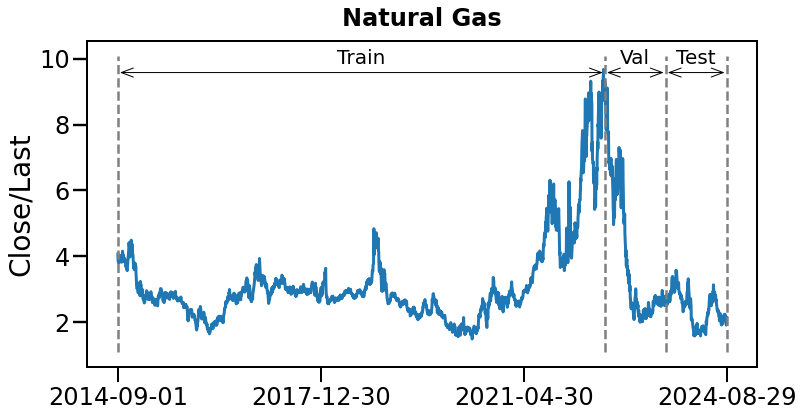

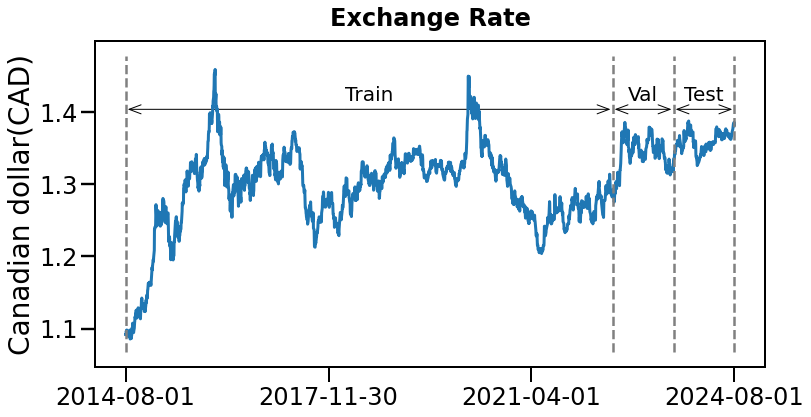

In [83]:
for dataset in datasets:
    if dataset == 'Financial_Aid_State': continue
    # print(dataset)
    df = pd.read_csv(f'data/{dataset}.csv')
    
    if dataset == 'Exchange_Rate_Report':
        target = 'Canadian dollar(CAD)'
    else:
        target = 'Close/Last'
        
    if df[target].dtype == 'object':
        df[target] = df[target].apply(
            lambda x: x.replace('$', '')
        ).astype('float')
    
    df['Date'] = pd.to_datetime(df['Date'])

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(df['Date'], df[target], linewidth=3)
    # ax.set_xlabel('Date')
    ax.set_ylabel(target)
    # plt.savefig('results/Financial_Aid_State_raw.jpg', dpi=200, bbox_inches="tight") 

    # fix x axis
    x_first_tick = df['Date'].min()
    x_last_tick = df['Date'].max() 
    x_major_ticks = 4
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )

    # fix y axis
    y_min, y_max = ax.get_ylim()
    # ax.set_ylim(y_min, y_max*1.1)
    ax.set_title(f'{datasets_map[dataset]}', fontweight='bold')
    
    if y_max > 500:
        label_text = []
        scale, unit = 1e3, 'K'
        for loc in plt.yticks()[0]:
            if loc == 0:
                label_text.append('0')
            else:
                label_text.append(f'{loc/scale:0.5g}{unit}') 
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(label_text)
    
    # add annotations for train, test, validation
    days = (x_last_tick - x_first_tick).days
    num_train = int(days * 0.8)
    num_test = int(days * 0.1)
    num_val = days - num_train - num_test
    
    train_end = x_first_tick + pd.to_timedelta(num_train, unit='D')
    val_end = train_end + pd.to_timedelta(num_val, unit='D')
    text_y = y_max*.95
    
    for label, start, end in [
        ('Train', x_first_tick, train_end), 
        ('Val', train_end, val_end),
        ('Test', val_end, x_last_tick)]:
        arr = mpatches.FancyArrowPatch((start, text_y), (end, text_y),
                               arrowstyle='<->,head_width=.15', mutation_scale=30)
        ax.add_patch(arr)
        ax.annotate(label, (.5, 1), xycoords=arr, ha='center', va='bottom', fontsize=20)    
    
    for x in [x_first_tick, train_end, val_end, x_last_tick]:
        ax.vlines(x, y_min, y_max, colors='gray', linestyles='dashed')
        
    plt.savefig(f'results/{dataset}.jpg', dpi=200, bbox_inches="tight")
    plt.show()
    # break

## Grid

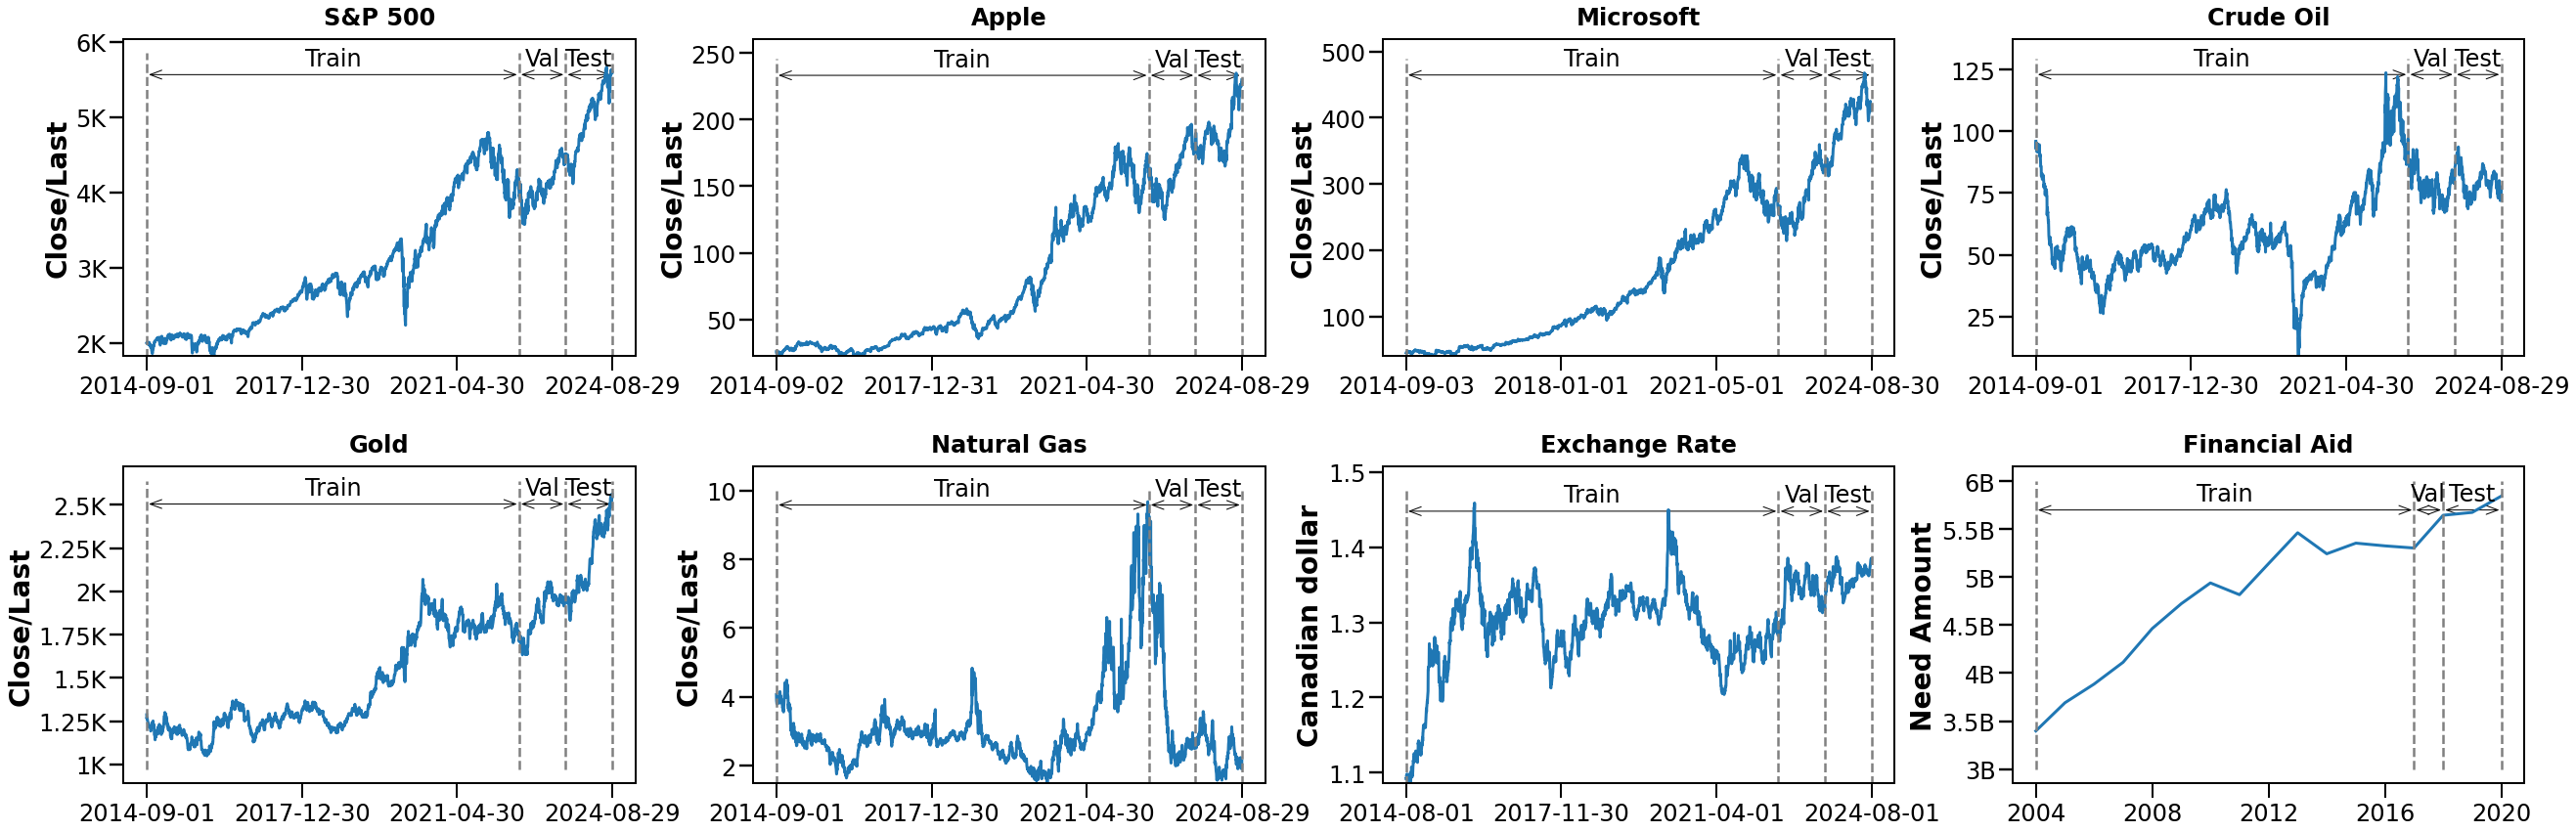

In [130]:
fig, axes = plt.subplots(2, 4, figsize=(44, 14))

for index, dataset in enumerate(datasets):
    df = pd.read_csv(f'data/{dataset}.csv')
    ax = axes[index // 4, index % 4]
    ax.set_title(f'{datasets_map[dataset]}', fontweight='bold')
    
    if dataset == 'Financial_Aid_State':
        df = df.groupby('Date')['need_amt'].sum().reset_index()
        ax.plot(df['Date'], df['need_amt'], linewidth=3)
        # ax.set_xlabel('Year', fontweight='bold')
        ax.set_ylabel('Need Amount', fontweight='bold')
        ax.xaxis.set_major_locator(MultipleLocator(base=4))

        label_text = []
        scale, unit = 1e9, 'B'
        for loc in plt.yticks()[0]:
            if loc == 0:
                label_text.append('0')
            else:
                label_text.append(f'{loc/scale:0.5g}{unit}') 
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(label_text)

        y_min, y_max = ax.get_ylim()

        x_first_tick = df['Date'].min()
        x_last_tick = df['Date'].max() 

        years = (x_last_tick - x_first_tick) + 1
        num_train = int(years * 0.8)
        num_val = int(years * 0.1)
        lnum_test = years - num_train - num_val

        train_end = x_first_tick + num_train
        val_end = train_end + num_val
        text_y = y_max*.95

        for label, start, end in [
            ('Train', x_first_tick, train_end), 
            ('Val', train_end, val_end),
            ('Test', val_end, x_last_tick)]:
            arr = mpatches.FancyArrowPatch((start, text_y), (end, text_y),
                                    arrowstyle='<->,head_width=.15', mutation_scale=30)
            ax.add_patch(arr)
            ax.annotate(label, (.5, 1), xycoords=arr, ha='center', va='bottom', fontsize=24)    

        for x in [x_first_tick, train_end, val_end, x_last_tick]:
            ax.vlines(x, y_min, y_max, colors='gray', linestyles='dashed')
        continue

    # print(dataset)
    
    
    if dataset == 'Exchange_Rate_Report':
        target = 'Canadian dollar(CAD)'
    else:
        target = 'Close/Last'
        
    if df[target].dtype == 'object':
        df[target] = df[target].apply(
            lambda x: x.replace('$', '')
        ).astype('float')
    
    df['Date'] = pd.to_datetime(df['Date'])

    ax.plot(df['Date'], df[target], linewidth=3)
    # ax.set_xlabel('Date')
    if target == 'Canadian dollar(CAD)':
        ax.set_ylabel('Canadian dollar', fontweight='bold')
    else:
        ax.set_ylabel(target, fontweight='bold')
    # plt.savefig('results/Financial_Aid_State_raw.jpg', dpi=200, bbox_inches="tight") 

    # fix x axis
    x_first_tick = df['Date'].min()
    x_last_tick = df['Date'].max() 
    x_major_ticks = 4
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )
    
    y_min, y_max = ax.get_ylim()
    if y_max > 1000:
        label_text = []
        scale, unit = 1e3, 'K'
        for loc in ax.get_yticks():
            if loc == 0:
                label_text.append('0')
            else:
                label_text.append(f'{loc/scale:0.5g}{unit}') 
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(label_text)

    # fix y axis
    
    if dataset == 'SPX500': ax.set_ylim(df[target].min(), y_max*1.03)
    elif dataset in ['Exchange_Rate_Report', 'Gold', 'SPX500']:
        if dataset != 'Gold': ax.set_ylim(df[target].min(), y_max*1.02)
    else: ax.set_ylim(df[target].min(), y_max*1.06)
    
    # add annotations for train, test, validation
    days = (x_last_tick - x_first_tick).days
    num_train = int(days * 0.8)
    num_test = int(days * 0.1)
    num_val = days - num_train - num_test
    
    train_end = x_first_tick + pd.to_timedelta(num_train, unit='D')
    val_end = train_end + pd.to_timedelta(num_val, unit='D')
    
    if dataset == 'Exchange_Rate_Report':
        text_y = y_max*0.98
    else: text_y = y_max*.95
    
    for label, start, end in [
        ('Train', x_first_tick, train_end), 
        ('Val', train_end, val_end),
        ('Test', val_end, x_last_tick)]:
        arr = mpatches.FancyArrowPatch((start, text_y), (end, text_y),
                               arrowstyle='<->,head_width=.15', mutation_scale=30)
        ax.add_patch(arr)
        ax.annotate(label, (.5, 1), xycoords=arr, ha='center', va='bottom', fontsize=24)    
    
    for x in [x_first_tick, train_end, val_end, x_last_tick]:
        ax.vlines(x, y_min, y_max, colors='gray', linestyles='dashed')
        
plt.subplots_adjust(wspace=0.23, hspace=0.35)
plt.savefig(f'results/All_raw.jpg', dpi=200, bbox_inches="tight")
plt.show()
    # break